## Python Data fitting with various functions - HW 12
Due Monday Dec 2, 2024



Dowload the data "miniDR17.fits" from the TCU Online Week 14:<br>
<i>NOTE: it is a large-ish file and may take a while.</i>

**However, this is a small version of the full science data file (4 GB) which can be found at:**<br>
https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStar-dr17-synspec_rev1.fits


My example below will show how to remove Identified bad data, 
however data that are just bad in one quantity may remain

_Use masking to remove any remaining bad values (typically 9999 or -9999 in this file_ , <b>but check!!!! If you are not sure, ask!!!</b>). 

In [8]:
from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits 
import scipy.optimize as opt

# POTENTIAL FITTING FUNCTIONS
def linear(x,m,b):
    return m*x+b

def poly2(x,a,b,c):
    return a*(x**2)+(b*x)+c

def poly3(x,a,b,c,d):
    return (a*(x**3))+(b*(x**2))+(c*x)+d

def cosfit (x,a,b,c,d):
    return a*np.cos(b*x + c) + d

def exponential(x,a,b,c,d):
    return a*np.exp(b*x + c) + d


# Monte Carlo-version of 2 parameter Curve Fit that can use BOTH x and Y errors
def mcFit2(func, x, y, x_err=0.1, y_err=0.1, p0=[0,0]):
    slope = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        slope.append(popt[0])
        y_ints.append(popt[1])
    return (np.median(slope),np.median(y_ints))


# Monte Carlo-version of 3 parameter Curve Fit that can use BOTH x and Y errors
def mcFit3(func, x, y, x_err=0.1, y_err=0.1,p0=[1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
    return (np.median(paramA),np.median(paramB),np.median(paramC))

# Monte Carlo-version of 4 parameter Curve Fit that can use BOTH x and Y errors
def mcFit4(func, x, y, x_err=0.1, y_err=0.1, p0=[1,1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    paramD = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
        paramD.append(popt[3])
    return (np.median(paramA),np.median(paramB),np.median(paramC),np.median(paramD))


In [9]:
# READ IN FITS FILES
star_hdus = fits.open('miniDR17.fits')
star = star_hdus[1].data
print(star_hdus[1].columns)
star_hdus.close()

ColDefs(
    name = 'APOGEE_ID'; format = '30A'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'TEFF'; format = 'E'
    name = 'TEFF_ERR'; format = 'E'
    name = 'LOGG'; format = 'E'
    name = 'LOGG_ERR'; format = 'E'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'SNR'; format = 'E'
    name = 'VHELIO_AVG'; format = 'E'
    name = 'VERR'; format = 'E'
    name = 'FE_H'; format = 'E'
    name = 'FE_H_ERR'; format = 'E'
    name = 'O_FE'; format = 'E'
    name = 'O_FE_ERR'; format = 'E'
    name = 'NI_FE'; format = 'E'
    name = 'NI_FE_ERR'; format = 'E'
    name = 'NVISITS'; format = 'J'
    name = 'VSCATTER'; format = 'E'
    name = 'ASPCAPFLAG'; format = 'K'
    name = 'STARFLAG'; format = 'K'
    name = 'EXTRATARG'; format = 'J'
    name = 'GAIA_PARALLAX'; format = 'E'
    name = 'GAIA_PARALLAX_ERROR'; for

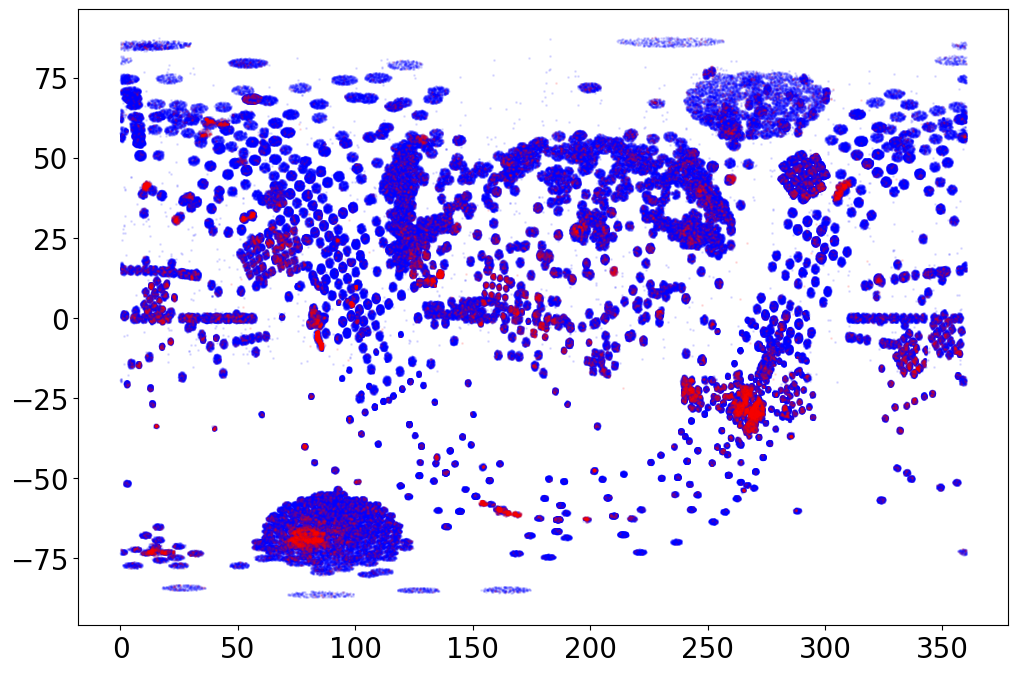

In [10]:
# TWO BITWISE FLAGS FOR BAD DATA - THESE REMOVE IDENTIFIED BAD DATA            
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

# Make a Boolena Mask to remove bad data
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) 
bd = (np.bitwise_and(star['aspcapflag'], badbits) != 0) |\
     (np.bitwise_and(star['starflag'], suspectbits) != 0) 

good = np.where(gd)[0]
bad = np.where(bd)[0]

# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter(star['RA'][good],star['DEC'][good],s=1,c='b',alpha=0.1)
ax.scatter(star['RA'][bad],star['DEC'][bad],s=1,c='r',alpha=0.1)


ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.show()

LINEAR: -0.074, 16.223
POLY2: 0.005, -1.877, 130.634
COSFIT: 72.947, 0.018, -0.452, -5.700


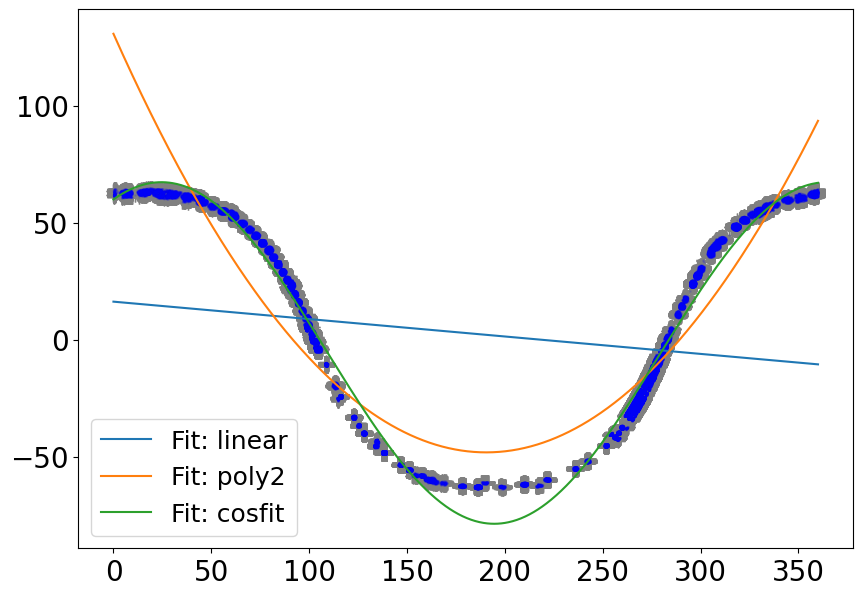

In [11]:
# EXAMPLE FIT - DR. FRINCHABOY
# --------------------------------------------
# First use Linear, Polnomial, and Cosine Fits
# Select stars only with with  −2 < GLAT < 2   
# 
# I FIT RA & DEC data versus LINEAR, POLY2, AND COSFIT in this example.  
#
# TWO BITWISE FLAGS TO REMOVE FOR OBVIOUSLY BAD DATA             
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

#=================================================================================
# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
# (e.g., −2 < GLAT < 2 ) or other 'bad' data not removed by the flags.
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['GLAT'] < 2) &\
     (star['GLAT'] > -2) 
cut1 = np.where(ct1)[0]

#=================================================================================
## LINEAR FIT (2 parameter)
slope, intercept = mcFit2(linear, star['RA'][cut1], star['DEC'][cut1], 0.001, \
                          0.001, p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

#=================================================================================
## POLY2 FIT (3 parameter)
polyA, polyB, polyC,  = mcFit3(poly2, star['RA'][cut1], star['DEC'][cut1], 0.001, \
                         0.001,p0=[600,1,1])
print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

#=================================================================================
## COS FIT (4 parameter)
cfA, cfB, cfC, cfD = mcFit4(cosfit, star['RA'][cut1], star['DEC'][cut1], 0.001, \
                            0.001,p0=[60,0.02,0,0])
print(f'COSFIT: {cfA:.3f}, {cfB:.3f}, {cfC:.3f}, {cfD:.3f}')
#=================================================================================



# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['RA'][cut1],star['DEC'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['RA'][cut1]),star['DEC'][cut1], xerr=(0.001),
             yerr=(0.001), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(0,360,1000) # X-PLOTING FOR FITS

#=================================================================================
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')
#poly2 fit
ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC), label='Fit: poly2')
#cosfit
ax1.plot(x_plot,cosfit(x_plot, cfA, cfB, cfC, cfD), label='Fit: cosfit')

plt.legend(loc='best', fontsize=18)
plt.show()

# Homework #12

**REMINDER:** *All coding assignment will be turned in as .ipynb files, to the same PHYS_X0223 repository on GitHub.*   
*They should be turned in with the following naming:*
    
    Lastname_Firstinitial_24_HW12a.ipynb

## DATA FIT 1

Fit a linear, polynomial (poly2), and a polynomial (poly3) functions and to the following selections of the data:
1. Select stars only with with $ GLAT > 20$ <br>
   __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

The best fit values are:
LINEAR: -0.233, 0.054
POLY2: -0.074, -0.317, 0.048
POLY3: 0.075, 0.093, -0.262, 0.045


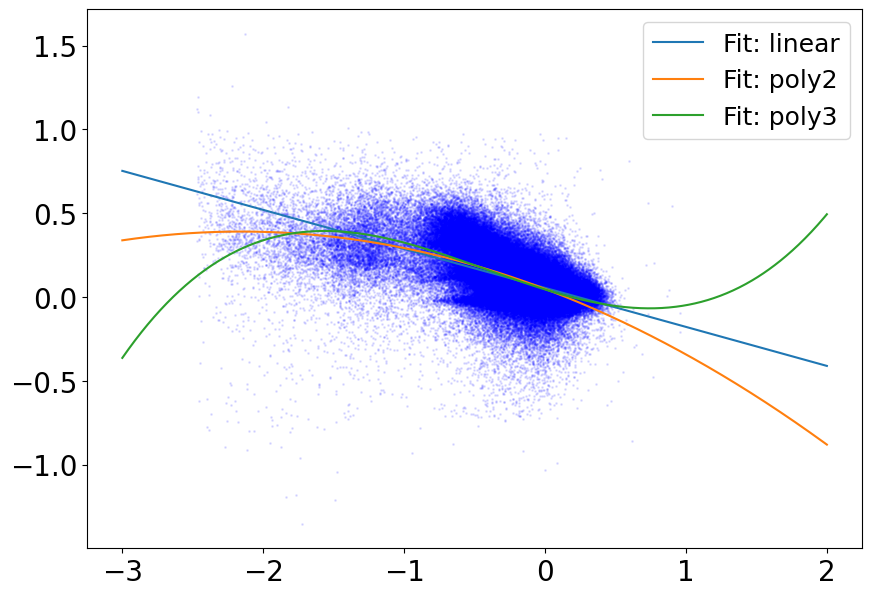

The best fit for this population is hard to tell. I would say linear or ploy3


In [52]:
import numpy as np
# write your fitting code, from part 1, and plot the results here
# EXAMPLE FIT - DR. FRINCHABOY
# --------------------------------------------
# First use Linear, Polnomial, and Cosine Fits
# Select stars only with with  −2 < GLAT < 2   
# 
# I FIT RA & DEC data versus LINEAR, POLY2, AND COSFIT in this example.  
#
# TWO BITWISE FLAGS TO REMOVE FOR OBVIOUSLY BAD DATA             
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

#=================================================================================
# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
# (e.g., −2 < GLAT < 2 ) or other 'bad' data not removed by the flags.
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['GLAT'] > 20) &\
    np.invert(np.isnan(star['FE_H'])) &\
    np.invert(np.isnan(star['O_FE']))    
# we take every value that is not nan
cut1 = np.where(ct1)[0]
print("The best fit values are:")
#=================================================================================
## LINEAR FIT (2 parameter)
slope, intercept = mcFit2(linear, star['FE_H'][cut1], star['O_FE'][cut1], 0.001, 0.001, p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

#=================================================================================
## POLY2 FIT (3 parameter)
polyA, polyB, polyC,  = mcFit3(poly2, star['FE_H'][cut1], star['O_FE'][cut1], 0.001, 0.001,p0=[1,1,1])
print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

## POLY3 FIT (4 parameter)
poly3A, poly3B, poly3C, poly3D  = mcFit4(poly3, star['FE_H'][cut1], star['O_FE'][cut1], 0.001, 0.001,p0=[600,1,1,1])
print(f'POLY3: {poly3A:.3f}, {poly3B:.3f}, {poly3C:.3f}, {poly3D:.3f}')

#=================================================================================
## COS FIT (4 parameter)
#cfA, cfB, cfC, cfD = mcFit4(cosfit, star['FE_H'][cut1], star['O_FE'][cut1], 0.001, 0.001,p0=[5,0.02,0,0])
#print(f'COSFIT: {cfA:.3f}, {cfB:.3f}, {cfC:.3f}, {cfD:.3f}')
#=================================================================================



# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['FE_H'][cut1],star['O_FE'][cut1],s=1,c='b',alpha=0.1)
# ax1.errorbar((star['FE_H'][cut1]),star['O_FE'][cut1], xerr=(0.001),
#              yerr=(0.001), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(-3,2,1000) # X-PLOTING FOR FITS

#=================================================================================
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')
#poly2 fit
ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC), label='Fit: poly2')
#poly3 fit
ax1.plot(x_plot,poly3(x_plot, poly3A, poly3B, poly3C, poly3D), label='Fit: poly3')
#cosfit
#ax1.plot(x_plot,cosfit(x_plot, cfA, cfB, cfC, cfD), label='Fit: cosfit')

plt.legend(loc='best', fontsize=18)
plt.show()

print("The best fit for this population is hard to tell. I would say linear or ploy3")

In [68]:
print("I would say there is one population of data. There are some off values but it's still one group of data points. I couldn't fit any linear trendline to the outliers")

I would say there is one population of data. There are some off values but it's still one group of data points. I couldn't fit any linear trendline to the outliers


In [15]:
np.isnan(star['FE_H'])

array([False, False, False, ..., False, False, False])

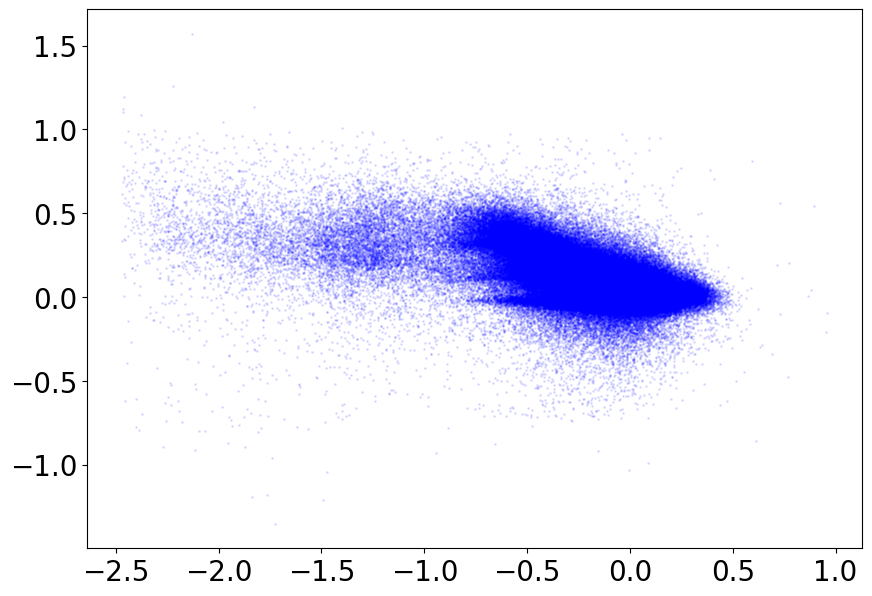

In [16]:
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['FE_H'][cut1],star['O_FE'][cut1],s=1,c='b',alpha=0.1)

## DATA FIT 2

Fit a linear, polynomial (poly2), and a polynomial (poly3) functions and to the following selections of the data:
2. Select stars only with with $-1< GLAT < 1$ <br>
   __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

The best fit values are:
LINEAR: -0.137, 0.040
POLY2: -0.020, -0.146, 0.041
POLY3: 0.091, 0.131, -0.131, 0.033


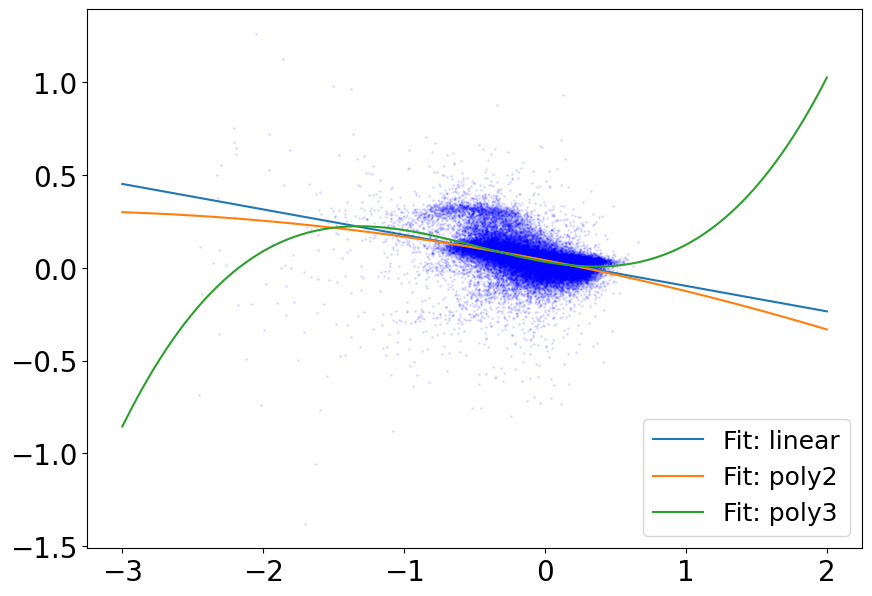

The best fit for this population is hard to tell. I would say linear or ploy2


In [62]:
import numpy as np
# write your fitting code, from part 1, and plot the results here
# EXAMPLE FIT - DR. FRINCHABOY
# --------------------------------------------
# First use Linear, Polnomial, and Cosine Fits
# Select stars only with with  −2 < GLAT < 2   
# 
# I FIT RA & DEC data versus LINEAR, POLY2, AND COSFIT in this example.  
#
# TWO BITWISE FLAGS TO REMOVE FOR OBVIOUSLY BAD DATA             
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

#=================================================================================
# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
# (e.g., −2 < GLAT < 2 ) or other 'bad' data not removed by the flags.
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['GLAT'] > -1) & (star['GLAT'] < 1) & \
    np.invert(np.isnan(star['FE_H'])) &\
    np.invert(np.isnan(star['O_FE']))    
# we take every value that is not nan
cut1 = np.where(ct1)[0]
print("The best fit values are:")
#=================================================================================
## LINEAR FIT (2 parameter)
slope, intercept = mcFit2(linear, star['FE_H'][cut1], star['O_FE'][cut1], 0.001, 0.001, p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

#=================================================================================
## POLY2 FIT (3 parameter)
polyA, polyB, polyC,  = mcFit3(poly2, star['FE_H'][cut1], star['O_FE'][cut1], 0.001, 0.001,p0=[1,1,1])
print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

## POLY3 FIT (4 parameter)
poly3A, poly3B, poly3C, poly3D  = mcFit4(poly3, star['FE_H'][cut1], star['O_FE'][cut1], 0.001, 0.001,p0=[600,1,1,1])
print(f'POLY3: {poly3A:.3f}, {poly3B:.3f}, {poly3C:.3f}, {poly3D:.3f}')

#=================================================================================
## COS FIT (4 parameter)
#cfA, cfB, cfC, cfD = mcFit4(cosfit, star['FE_H'][cut1], star['O_FE'][cut1], 0.001, 0.001,p0=[5,0.02,0,0])
#print(f'COSFIT: {cfA:.3f}, {cfB:.3f}, {cfC:.3f}, {cfD:.3f}')
#=================================================================================



# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['FE_H'][cut1],star['O_FE'][cut1],s=1,c='b',alpha=0.1)
# ax1.errorbar((star['FE_H'][cut1]),star['O_FE'][cut1], xerr=(0.001),
#              yerr=(0.001), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(-3,2,1000) # X-PLOTING FOR FITS

#=================================================================================
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')
#poly2 fit
ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC), label='Fit: poly2')
#poly3 fit
ax1.plot(x_plot,poly3(x_plot, poly3A, poly3B, poly3C, poly3D), label='Fit: poly3')
#cosfit
#ax1.plot(x_plot,cosfit(x_plot, cfA, cfB, cfC, cfD), label='Fit: cosfit')

plt.legend(loc='best', fontsize=18)
plt.show()

print("The best fit for this population is hard to tell. I would say linear or ploy2")

In [64]:
print("I would say you can see the second population you could fit a linear trend to. It's the data above our population. It's location is about 0.4 on y axis and (-1;0) on x axis")

I would say you can see the second population you could fit a linear trend to. It's the data above our population. It's location is about 0.4 on y axis and (-1;0) on x axis


## DATA FIT 3

Fit a linear, polynomial (poly3), and a exponetial functions and to the following selections of the data:
3. Select stars only with with $340 < GLON < 360$ <br>
   __Fit TEFF,  (TEFF\_ERR)  vs.  LOGG (LOGG\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

In [124]:
import numpy as np
         
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

#=================================================================================
# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
# (e.g., −2 < GLAT < 2 ) or other 'bad' data not removed by the flags.
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['GLON'] > 340) & (star['GLON'] < 360) & \
    np.invert(np.isnan(star['TEFF'])) &\
    np.invert(np.isnan(star['LOGG']))    
# we take every value that is not nan
cut1 = np.where(ct1)[0]
print("The best fit values are:")
#=================================================================================
## LINEAR FIT (2 parameter)
slope, intercept = mcFit2(linear, star['TEFF'][cut1], star['LOGG'][cut1], 0.001, 0.001, p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

#=================================================================================
## POLY2 FIT (3 parameter)
#polyA, polyB, polyC,  = mcFit3(poly2, star['TEFF'][cut1], star['LOGG'][cut1], 0.001, 0.001,p0=[1,1,1])
#print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

#=================================================================================
## EXPO FIT (4 parameter)
expoA, expoB, expoC, expoD  = mcFit4(exponential, star['TEFF'][cut1], star['LOGG'][cut1], 0.001, 0.001,p0=[4,5e-4,-3,1])
print(f'exponential: {expoA:.3f}, {expoB:.3f}, {expoC:.3f}, {expoD:.3f}')

## POLY3 FIT (4 parameter)
poly3A, poly3B, poly3C, poly3D  = mcFit4(poly3, star['TEFF'][cut1], star['LOGG'][cut1], 0.001, 0.001,p0=[1,1,1,1])
print(f'POLY3: {poly3A:.3f}, {poly3B:.3f}, {poly3C:.3f}, {poly3D:.3f}')

#=================================================================================
## COS FIT (4 parameter)
#cfA, cfB, cfC, cfD = mcFit4(cosfit, star['FE_H'][cut1], star['O_FE'][cut1], 0.001, 0.001,p0=[5,0.02,0,0])
#print(f'COSFIT: {cfA:.3f}, {cfB:.3f}, {cfC:.3f}, {cfD:.3f}')
#=================================================================================

# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['TEFF'][cut1],star['LOGG'][cut1],s=1,c='b',alpha=0.1)
# ax1.errorbar((star['FE_H'][cut1]),star['O_FE'][cut1], xerr=(0.001),
#              yerr=(0.001), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(3000,7000,1000) # X-PLOTING FOR FITS

#=================================================================================
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')
#poly2 fit
#ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC), label='Fit: poly2')
#poly3 fit
ax1.plot(x_plot,poly3(x_plot, poly3A, poly3B, poly3C, poly3D), label='Fit: poly3')
#cosfit
#ax1.plot(x_plot,cosfit(x_plot, cfA, cfB, cfC, cfD), label='Fit: cosfit')
#expo fit
ax1.plot(x_plot,exponential(x_plot, expoA, expoB, expoC, expoD), label='Fit: expo')
plt.legend(loc='best', fontsize=18)
plt.show()

print("The best fit for this population is hard to tell. I would say linear or ploy2")

The best fit values are:
LINEAR: 0.000, 0.347


/var/folders/sp/fnkyxkr106qfb7h89l67n_lx6stpbv/T/ipykernel_41288/3954844722.py:71: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
/var/folders/sp/fnkyxkr106qfb7h89l67n_lx6stpbv/T/ipykernel_41288/4137333828.py:11: RuntimeWarning: overflow encountered in exp
  return a*np.exp(b*x + c) + d
/var/folders/sp/fnkyxkr106qfb7h89l67n_lx6stpbv/T/ipykernel_41288/4137333828.py:11: RuntimeWarning: overflow encountered in multiply
  return a*np.exp(b*x + c) + d


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

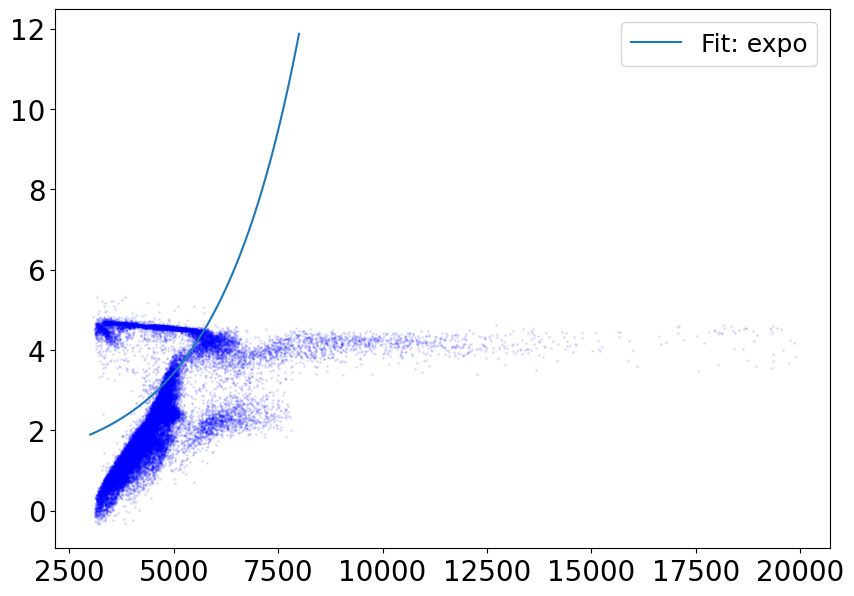

In [122]:
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

ax1.scatter(star['TEFF'][cut1],star['LOGG'][cut1],s=1,c='b',alpha=0.1)
# ax1.errorbar((star['FE_H'][cut1]),star['O_FE'][cut1], xerr=(0.001),
#              yerr=(0.001), ecolor='grey',fmt='none', capsize=5, zorder=0)

def exponential(x,a,b,c,d):
    return a*np.exp(b*x + c) + d
#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(3000,8000,1000) # X-PLOTING FOR FITS

#=================================================================================
#linear fit
# ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')
#poly2 fit
#ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC), label='Fit: poly2')
#poly3 fit
# ax1.plot(x_plot,poly3(x_plot, poly3A, poly3B, poly3C, poly3D), label='Fit: poly3')
#cosfit
#ax1.plot(x_plot,cosfit(x_plot, cfA, cfB, cfC, cfD), label='Fit: cosfit')
#expo fit
ax1.plot(x_plot,exponential(x_plot, 4, 5e-4, -3, 1), label='Fit: expo')
plt.legend(loc='best', fontsize=18)
plt.show()
# print(exponential(x_plot, 4, 3e4, 1, 1))

## DATA FIT 4

Fit  a linear, a exponential, and a polynomial (poly2) functions and to the following selections of the data:
4. Select stars only with with $DEC < -50$ and $50 < RA < 120$ <br>
   __Fit TEFF,  (TEFF\_ERR)   vs.  (star['J'] - star['K']) (JK_ERR)__<br>
<br>
<b>NOTE: you will have to create a (J-K) error:</b>  JK_ERR = np.sqrt( J\_ERR^2 + K\_ERR^2 )<br> 

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

In [22]:
# write your fitting code and plot the results here

## DATA FIT 5

Fit  a linear, a polynomial (poly3), and a cosfit functions and to the following selections of the data:
5. Select stars only with with $-10< GLAT < 10$<br>
   __Fit GLON (0.0001) vs.  VHEILO\_AVG (VERR)__<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

In [24]:
# write your fitting code and plot the results here

## DATA FIT 6

Fit  a linear and a polynomial (poly2 AND poly3) functions and to the following selections of the data:
7. __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  NI\_FE (NI\_FE\_ERR)__<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

In [26]:
# write your fitting code and plot the results here